# Train Your Own Model and Convert It to TFLite

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib


# Download Fashion MNIST Dataset


In [4]:
(train_examples, validation_examples, test_examples) , info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=['train[80%:]', 'train[80%:90%]', 'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJHIY8V/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJHIY8V/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
num_classes

10

In [6]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [8]:
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [22]:
# Write a function to normalize and resize the images

def format_example(image, label):
  # Cast image to float32
  image = tf.cast(image,  tf.float32)
  # Resize the image if necessary
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  # Normalize the image in the range [0, 1]
  image = image/255.0
  return image, label

In [23]:
# Set the batch size to 32

BATCH_SIZE = 32

## Create a Dataset from images and labels

In [24]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = train_examples.cache().shuffle(num_examples //4).map(format_example).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_example).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_example).batch(1)

# Building the model

In [26]:
# """
# Model: "sequential"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d (Conv2D)              (None, 26, 26, 16)        160       
# _________________________________________________________________
# max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
# _________________________________________________________________
# conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
# _________________________________________________________________
# flatten (Flatten)            (None, 3872)              0         
# _________________________________________________________________
# dense (Dense)                (None, 64)                247872    
# _________________________________________________________________
# dense_1 (Dense)              (None, 10)                650       
# =================================================================
# Total params: 253,322
# Trainable params: 253,322
# Non-trainable params: 0
# """

In [28]:
# Build the model shown in the previous cell


model = tf.keras.Sequential([
  # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,  
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),    
  tf.keras.layers.MaxPooling2D(),
  # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
  tf.keras.layers.Conv2D(32,3, activation = 'relu'),
  # Flatten the output layer to 1 dimension
  tf.keras.layers.Flatten(),
  # Add a fully connected layer with 64 hidden units and ReLU activation
  tf.keras.layers.Dense(64, activation= 'relu'),
  # Attach a final softmax classification head
  tf.keras.layers.Dense(10 , activation= 'softmax')])

# Set the loss and accuracy metrics
model.compile(
    optimizer='adam', 
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[ 'accuracy'])
      

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
__________________________________________________

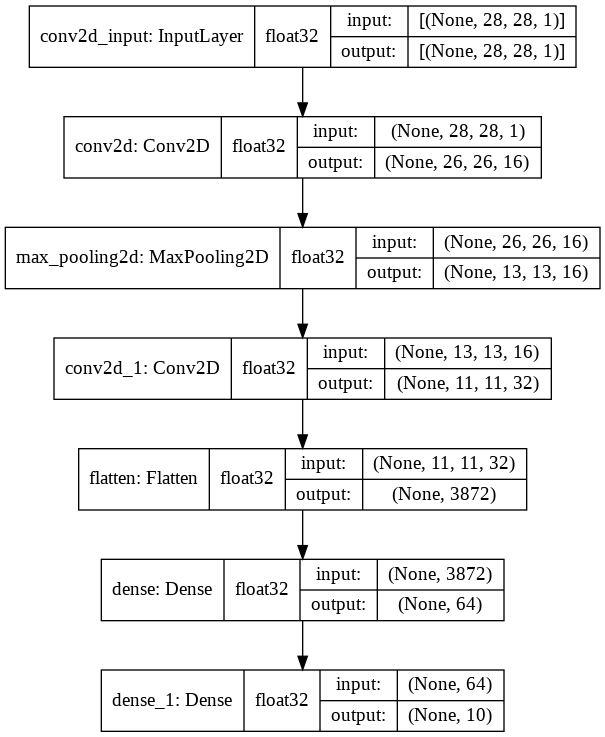

In [31]:
tf.keras.utils.plot_model(model, 'multilayer_model.png', show_shapes=True, show_dtype=True, show_layer_names=True)

## Train

In [32]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


375/375 [==============================] - 34s 6ms/step - loss: 0.6382 - accuracy: 0.7681 - val_loss: 0.4849 - val_accuracy: 0.8147
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3988 - accuracy: 0.8558 - val_loss: 0.3215 - val_accuracy: 0.8815
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3406 - accuracy: 0.8761 - val_loss: 0.2810 - val_accuracy: 0.8953
Epoch 4/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3023 - accuracy: 0.8888 - val_loss: 0.2507 - val_accuracy: 0.9098
Epoch 5/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2623 - accuracy: 0.9036 - val_loss: 0.2206 - val_accuracy: 0.9200
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.2366 - accuracy: 0.9137 - val_loss: 0.2363 - val_accuracy: 0.9110
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2138 - accuracy: 0.9197 - val_loss: 0.1753 - val_accuracy: 0.9348
Epoch 8/10
375/3

# Exporting to TFLite

In [36]:
export_dir = '/content/saved_model'

# Use the tf.saved_model API to export the SavedModel
tf.saved_model.save(model,export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /content/saved_model/assets


INFO:tensorflow:Assets written to: /content/saved_model/assets


In [40]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [41]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

# Test if your model is working

In [42]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [45]:
output_index

16

In [46]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label[0])
  test_images.append(np.array(img))

In [50]:
# test_images

In [52]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'green'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(10)), class_names, rotation='vertical')
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

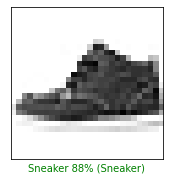

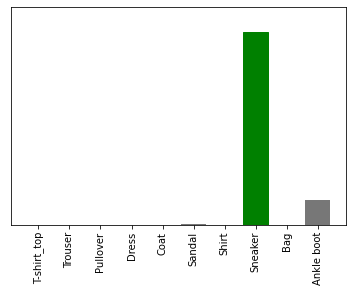

In [57]:
index = 24
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download TFLite model and assets

**NOTE: You might have to run to the cell below twice**

In [58]:
try:
  from google.colab import files
  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deploying TFLite model

Now once you've the trained TFLite model downloaded, you can ahead and deploy this on an Android/iOS application by placing the model assets in the appropriate location.

# Optional

In [59]:
!mkdir -p test_images

In [60]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [61]:
!ls test_images

'ankle boot_10.jpg'   coat_40.jpg       sandal_19.jpg	 sneaker_43.jpg
'ankle boot_32.jpg'   coat_46.jpg       sandal_2.jpg	 trouser_20.jpg
'ankle boot_4.jpg'    coat_48.jpg       sandal_39.jpg	 trouser_22.jpg
 bag_16.jpg	      dress_12.jpg      shirt_27.jpg	 trouser_35.jpg
 bag_17.jpg	      dress_29.jpg      shirt_33.jpg	 trouser_49.jpg
 bag_23.jpg	      dress_37.jpg      shirt_5.jpg	 t-shirt_top_15.jpg
 bag_34.jpg	      dress_45.jpg      sneaker_13.jpg	 t-shirt_top_18.jpg
 bag_36.jpg	      dress_6.jpg       sneaker_24.jpg	 t-shirt_top_1.jpg
 bag_3.jpg	      pullover_28.jpg   sneaker_25.jpg	 t-shirt_top_21.jpg
 bag_7.jpg	      pullover_44.jpg   sneaker_26.jpg	 t-shirt_top_47.jpg
 coat_11.jpg	      pullover_9.jpg    sneaker_38.jpg	 t-shirt_top_8.jpg
 coat_30.jpg	      sandal_0.jpg      sneaker_41.jpg
 coat_31.jpg	      sandal_14.jpg     sneaker_42.jpg


In [62]:
!zip -qq fmnist_test_images.zip -r test_images/

In [63]:
try:
  files.download('fmnist_test_images.zip')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>